In [1]:
import numpy as np

In [6]:
with open("jpn.txt", 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

#### Getting the corpus of english and japanese words

In [10]:
input_texts = []
target_texts = []
bos = "<BOS> "
eos = " <EOS>"

for line in lines:
    if len(line.split("\t")) == 2:
        input_text, target_text = line.split("\t")[0], line.split("\t")[1]
        target_text = bos + target_text + eos
        input_texts.append(input_text)
        target_texts.append(target_text)

len(input_texts)

43953

In [11]:
input_texts[0]

'Go.'

In [12]:
target_texts[0]

'<BOS> 行け。 <EOS>'

In [13]:
len(input_texts)

43953

In [14]:
len(target_texts)

43953

#### Charecters Building of Each type

In [18]:
input_charecters = set()

for text in input_texts:
    for i in text:
        if i not in input_charecters:
            input_charecters.add(i)

In [40]:
english_char_size = len(input_charecters)

In [25]:
max_eng_len = max([len(text) for text in input_texts])
max_jpn_len = max([len(text) for text in target_texts])

In [21]:
target_charecters = set()

for text in target_texts:
    for i in text:
        if i not in target_charecters:
            target_charecters.add(i)

In [43]:
japanese_char_size = len(target_charecters)

In [27]:
target_charecters = sorted(list(target_charecters))
input_charecters = sorted(list(input_charecters))

#### Charecter to index and index to charecter

In [29]:
input_char_index = dict([(char,i) for i,char in enumerate(input_charecters)])
target_char_index = dict([(char,i) for i,char in enumerate(target_charecters)])

In [37]:
input_index_char = dict((i, char) for char, i in input_char_index.items())
target_index_char = dict((i, char) for char, i in target_char_index.items())

#### Preparing the Encoding and the Decoding Data

In [ ]:
#3 dimensions - 1st dimension = no of corpus conversions 2nd-dim= no of rows = maxlen(of corpus) 3rd=len(char)
encoder_input_data = np.zeros((len(input_texts), max_eng_len, english_char_size))

decoder_input_data = np.zeros((len(input_texts), max_jpn_len, japanese_char_size))

decoder_output_data = np.zeros((len(input_texts), max_jpn_len, japanese_char_size))

###### Follow this link

https://github.com/samurainote/seq2seq_translate_slackbot/blob/master/0315_seq2seq_translater.ipynb

#### Buliding a model

we need 2 models encoder model and decoder model for training, encoder model will give its states to
the decoder model to predict the decoder_target variables

In [49]:
from keras.models import Model
from keras.layers import LSTM,Dense,Input

In [50]:
num_encoder_tokens = max_eng_len
num_decoder_tokems = max_jpn_len

##### Encoding 

In [52]:
#input_layer
encode_input = Input(shape=(None,num_encoder_tokens))
#lstm_layer
encode_lstm = LSTM(units = 256,return_state = True)
#encoder_ouputs and states we dont need encoder_outputs we only need states
encoder_ouput,state_h,state_c = encode_lstm(encode_input)
encode_states = [state_h,state_c]

##### Decoding 

In [57]:
#decoder input layer
decode_input = Input(shape=(None,num_decoder_tokems))
#lstm layer
decode_lstm = LSTM(units=256,return_state=True,return_sequences=True)
#returning states is for getting the sates and sequences is to give the same shaped input to the Dense Layer
decode_output,decode_h,encode_h = decode_lstm(decode_input,initial_state=encode_states)
#passing the output to a dense layer
decode_dense = Dense(units = 256,activation = 'softmax')
decode_output = decode_dense(decode_output)

model = Model([encode_input,decode_input],decode_output)

In [59]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 192)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 459776      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  365568      input_7[0][0]                    
                                                                 lstm[0][1]                 

#### Our model takes encoderinputs and decoderinputs and it should predict now decoder outputs and we fit it accordingly

In [58]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
          batch_size=64,
          epochs=50,
          validation_split=0.2)

model.save("seq2seq_translation.h5")

#### Taking Encoding and Decoding Models Now

In [60]:
#a model which takes in encoder_inputs and gives out encoder_states
#we takes this model and give in the english inputs and get the states

encoder_model = Model(encode_input,encode_states)

In [ ]:
decoder_input_state_h = Input(shape=(256,))
#hidden/cell states in rnns will always be in shape of (no of units,)
decoder_input_state_c = Input(shape=(256,))
#since we dont have encoder states initially we will create dummy decoder_states
decoder_input_states = [decoder_input_state_h,decoder_input_state_c]
decode_ouput,h,c = decode_lstm(decode_input,initial_state=decoder_input_states)
decoder_output_states = [h,c]
decode_output = decode_dense(decode_output)
#so we create a model whihc will take the decoded japanese letter and the corresponding english word encoded
#state and predicts the decoded_output(next letter) with encoded output states
decoder_model = Model([decode_input]+decoder_input_states,[decode_output]+decoder_output_states)

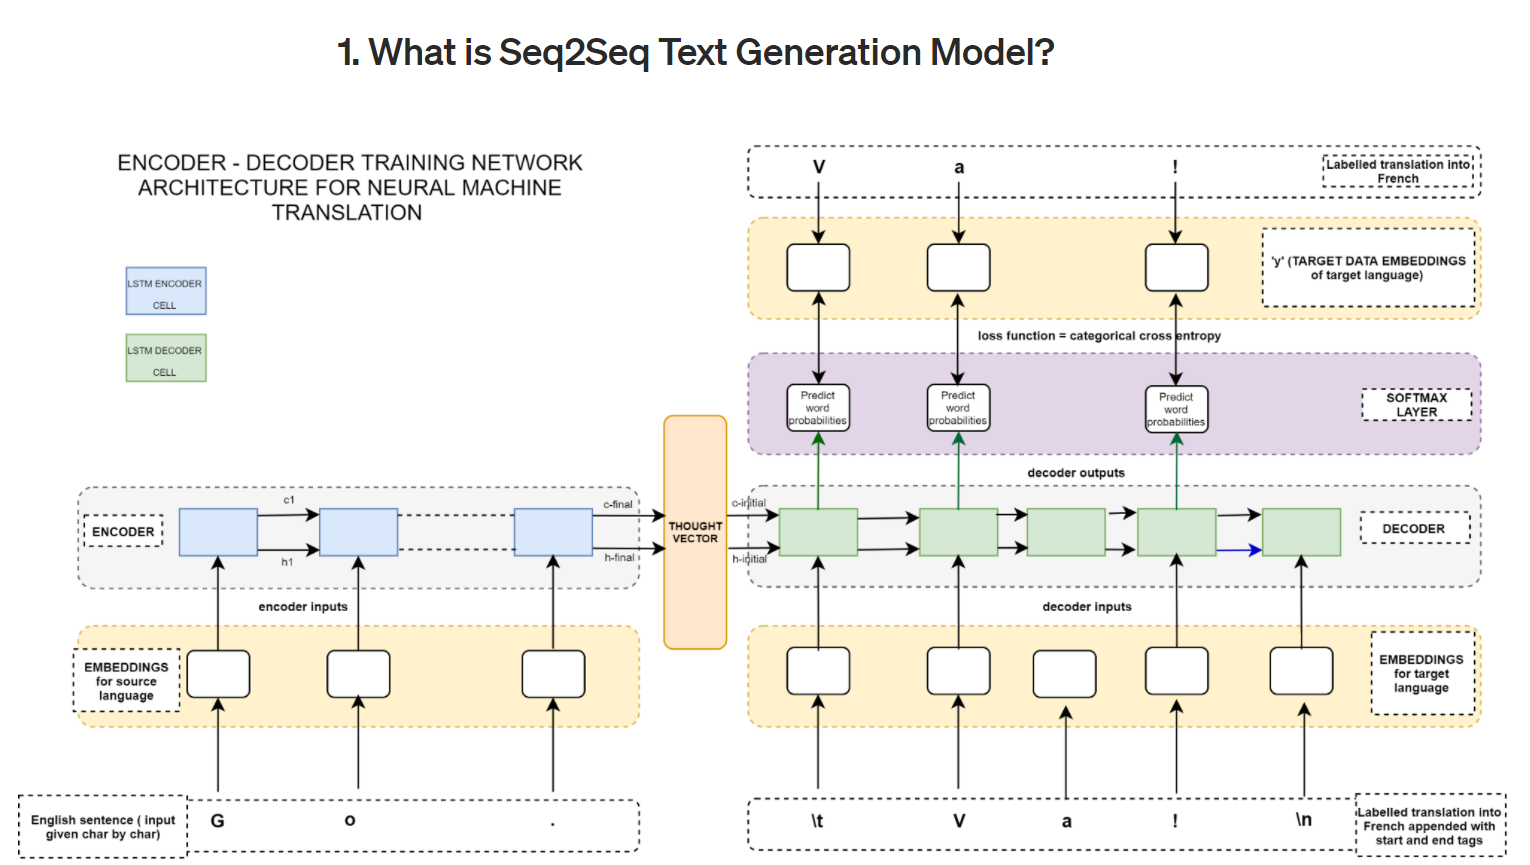

In [73]:
from PIL import Image
Image.open('NMT.png')

##### Predicting

In [ ]:
def inference_translater(english_input):
    
    encoder_states = encoder_model.predict(english_input)

    japanese_seq = np.zeros((1, 1, NUM_DECODER_TOKENS))
    #making the start of the word
    japanese_seq[0, 0, target_char_index[bos]] = 1.
    
    stop_condition = False
    japanese_output = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([japanese_seq] + encoder_states)
        # ソフトマックスが最大のcharのidを返す np.argmax
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # 日本語の単語に変換
        sampled_char = target_index_char[sampled_token_index]
        japanese_output += sampled_char

        # Exit condition: either hit max length or find stop character.
        if (sampled_char == eos or len(japanese_output) > japanese_maxlen):
            stop_condition = True

        japanese_seq = np.zeros((1, 1, NUM_DECODER_TOKENS))
        japanese_seq[0, 0, sampled_token_index] = 1.

        encoder_states = [_h, _c]

    return japanese_output